## TODO:

 * extract to class in .py file for better code reuse and overall cleanness. Separate the graphs in different sessions so that we can evaluate and infer while training at the same time.
 * better batching mechanism (maybe the prebuilt in TF)
 * try different optimizer (SGD with momentum, RMSProp) ?
 * learning rate decay ?
 * dropout, more layers, gradient clipping, bidirectional, ... ?
 * beam search

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re
import nltk
import tensorflow as tf
import itertools

## Prepare vocabulary and a training set

I load the Sherlock holmes corpus and process it as follows:
 * All is converted to lowercase, all whitespace collapsed to a single space
 * nltk is used to tokenize into sentences and words. Special tokens START and END are added to the beginning and end of each sentence
 * Only the first 500 sentences are used for training (for simplicity and speed of learning)
 * All words are kept. Later we may drop all words frequent less than a threshold, or replace them with UNKNOWN token
 * Longer sentences are trimmed to length of 50 words, shorter sentences are padded (and masking is used in the training).

In [2]:
with open('../txa-hw/hw2/pg1661.txt', encoding='utf-8') as f:
    original_text = f.read()
# Strip meta info and table of contents at the beginning and licence at the end -> use only the book itself.
text = original_text[re.search('ADVENTURE I', original_text).start() : re.search('End of the Project Gutenberg EBook', original_text).start()]
text = text.lower().strip()
text = re.sub('\s+', ' ', text) # replace whitespaces with single space

In [4]:
sentences = nltk.sent_tokenize(text)

token_start = 'START'
token_end = 'END'
tok_sentences = [[token_start] + [w for w in nltk.word_tokenize(s) if w] + [token_end] for s in sentences]

train_size = 500  # limit training set to this number of first sentences
tok_sentences = tok_sentences[:train_size]

In [5]:
freq_dist = nltk.FreqDist(itertools.chain(*tok_sentences))

freq_threshold = 0
vocab = [(k,v) for k,v in freq_dist.items() if v >= freq_threshold]
vocab_size = len(vocab)
id_word = [v[0] for v in vocab]
word_id = {w:i for i,w in enumerate(id_word)}

# drop all words not in vocabulary (less frequent than freq_threshold)
# maybe to replace them with special token would be better?
# now we actually don't drop anything
tok_sentences = [[w for w in s if w in word_id] for s in tok_sentences]

max_len = 50

# cut all sentences to max_len
tok_sentences = [s[:max_len] for s in tok_sentences]

In [6]:
vocab_size

1724

In [7]:
X = [[word_id[w] for w in s[:-1]] for s in tok_sentences]
Y = [[word_id[w] for w in s[1:]] for s in tok_sentences]  # shift-by-1 X, next-word prediction

X_lens = np.asarray([len(x) for x in X])
# Y_lens = [len(y) for y in Y]

# pad with zeros to max_len
X = np.asarray([np.pad(x, (0,max_len-len(x)), 'constant') for x in X])
Y = np.asarray([np.pad(y, (0,max_len-len(y)), 'constant') for y in Y])

## Build train and eval graphs

Two TensorFlow graphs are built. One for training and second for evaluation.

Architecture:
 * embedding layer (no bias, no activation) maps word indices to a dense vectors
 * RNN layer using LSTM cell
 * projection layer (bias, no activation) projecting RNN outputs to logits of size(vocabulary)
 * softmax layer providing us with nex_word probability distribution.
 
So far, both graps are the same.

In [8]:
num_steps = max_len  # max. number of timesteps
embeding_size = 100
input_size = X.shape[0]
batch_size = 32
lstm_size = 100 # n_hidden and state_size?

In [26]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [27]:
def build_model(input_, input_lengths, target):
    # Embedding layer
    embedding = tf.get_variable('E', initializer=tf.truncated_normal([vocab_size, embeding_size]))   # [V, E]
    embedded_input = tf.nn.embedding_lookup(embedding, input_) # [B, T, E]

    # RNN layer
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    outputs, final_state = tf.nn.dynamic_rnn(lstm, embedded_input, dtype=tf.float32, sequence_length=input_lengths)

    # Projection and softmax
    softmax_w = tf.get_variable('W_softmax', initializer=tf.truncated_normal([lstm_size, vocab_size]), dtype=tf.float32)   # [lstm_size, V]
    softmax_b = tf.get_variable('b_softmax', initializer=tf.zeros([vocab_size]))   # [V]
    logits = tf.tensordot(outputs, softmax_w, axes=[[2],[0]]) + tf.reshape(softmax_b, [1,1,-1]) # [B, T, V]
#     probabilities = tf.nn.softmax(logits) # [B, T, V]
    return logits

In [28]:
train_input = tf.placeholder(tf.int32, [batch_size, num_steps], name='train_input')   # [B, T]
train_input_lengths = tf.placeholder(tf.int32, [batch_size], name='train_input_lengths')   # [B]
train_target  = tf.placeholder(tf.int32, [batch_size, num_steps], name='train_target')   # [B, T]

eval_input = tf.placeholder(tf.int32, [input_size, num_steps], name='eval_input')
eval_input_lengths = tf.placeholder(tf.int32, [input_size], name='eval_input_lengths')
eval_target  = tf.placeholder(tf.int32, [input_size, num_steps], name='eval_target')

In [29]:
with tf.variable_scope('root'):
    train_logits = build_model(train_input, train_input_lengths, train_target)
with tf.variable_scope('root', reuse=True):
    eval_logits = build_model(eval_input, eval_input_lengths, eval_target)

## Calculate loss

The loss is categorical cross-entropy which is equal to a negative log-likelihood of a correct (target) word for each step:
$$\mathrm{loss} = - \sum_t \log p(\mathrm{correct\_word}_t)$$.
It is averaged over number of sentences and over number of words in a sentence.

The loss is added to both of the graphs.

In [30]:
def build_loss(logits, targets, input_lengths):
    ''' Crossentropy between probas and one-hot target = negative log-likelihood of a correct word. '''
    l = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets)
    mask = tf.sequence_mask(input_lengths, maxlen=num_steps, dtype=tf.float32) # [B, T]
    masked_l = tf.multiply(l, mask)   # [B, T]. Masking by seq. lenghts
    loss = tf.reduce_sum(masked_l) / tf.reduce_sum(mask)
    return loss

In [31]:
train_loss = build_loss(train_logits, train_target, train_input_lengths)
eval_loss = build_loss(eval_logits, eval_target, eval_input_lengths)

## Train model

Model is trained by feeding mini-batches of sentences. Adam optimizer with learning rate 0.1 is used. The loss on all training set is calculated every 10 steps using eval graph.

In [32]:
learning_rate = 0.01
train_op = tf.train.AdamOptimizer(learning_rate).minimize(train_loss)

In [33]:
sess.run(tf.global_variables_initializer())
losses = []
step = 0

In [34]:
n_epochs = 20
num_batches = train_size // batch_size

def train():
    global step
    for epoch in range(n_epochs):
        print('epoch', epoch+1)
        idx = np.random.permutation(X.shape[0])
        loss_epoch = 0.0
        for i in range(num_batches):
            step += 1
            start = i*batch_size
            end = (i+1)*batch_size
            b_ids = idx[start:end]
            x, y, x_lens = X[b_ids], Y[b_ids], X_lens[b_ids]
            sess.run(train_op, feed_dict={
                train_input: x, 
                train_input_lengths: x_lens,
                train_target: y
            })
            if step % 10 == 0:
                loss_value = sess.run(eval_loss, feed_dict={
                    eval_input: X, 
                    eval_input_lengths: X_lens,
                    eval_target: Y
                })
                losses.append(loss_value)
    print('finished')


# %load_ext line_profiler
# %lprun -f train train()
train()

final_loss_value = sess.run(eval_loss, feed_dict={
    eval_input: X, 
    eval_input_lengths: X_lens,
    eval_target: Y
})

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
finished


final loss 0.410672


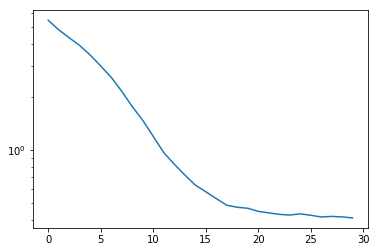

In [35]:
print('final loss', final_loss_value)
plt.semilogy(losses)

## Build infer graph

The next-word prediction is used to greedily generate sentences. For this purpose, a inference graph is created, that enables us to pass a word and a state of LSTM cell and get the new word and new state.

We can see that this simple model is quite overfit, the beginnings of the generated sentences largely match the sentences in the training set. This is on purpose to somewhat demonstrate the correctness that the model can actually learn the data.

In [36]:
def build_inference_graph(input_, input_lengths, state_feed):
    # Embedding layer
    embedding = tf.get_variable('E', initializer=tf.truncated_normal([vocab_size, embeding_size]))   # [V, E]
    embedded_input = tf.nn.embedding_lookup(embedding, input_) # [I, T, E]

    # RNN layer
    state_tuple = tf.contrib.rnn.LSTMStateTuple(*tf.unstack(state_feed, axis=0))
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    outputs, state = tf.nn.dynamic_rnn(lstm, embedded_input, dtype=tf.float32, sequence_length=input_lengths, initial_state=state_tuple)

    # Projection and softmax
    softmax_w = tf.get_variable('W_softmax', initializer=tf.truncated_normal([lstm_size, vocab_size]), dtype=tf.float32)   # [lstm_size, V]
    softmax_b = tf.get_variable('b_softmax', initializer=tf.zeros([vocab_size]))   # [V]
    logits = tf.tensordot(outputs, softmax_w, axes=[[2],[0]]) + tf.reshape(softmax_b, [1,1,-1]) # [B, T, V]
    probabilities = tf.nn.softmax(logits) # [B, T, V]
    return probabilities, state



In [37]:
infer_input = tf.placeholder(tf.int32, [None, 1], name='infer_input')   # [I]
infer_input_lengths = tf.placeholder(tf.int32, [None], name='infer_input_lengths')   # [I]
state_feed = tf.placeholder(dtype=tf.float32, shape=[2, 1, lstm_size], name='state_feed')  # [2, num_layers, lstm_size]

with tf.variable_scope('root', reuse=True):
    infer_probas, infer_final_state = build_inference_graph(infer_input, infer_input_lengths, state_feed)

## Generate text

In [39]:
seq = ['START']
seq = [word_id[s] for s in seq]
state = init_state = np.zeros((2, 1, lstm_size))

num_words = 500

for i in range(len(seq)-1, num_words):
    p, state = sess.run([infer_probas, infer_final_state], feed_dict={
        infer_input: np.reshape(seq[-1], (1,1)),
        infer_input_lengths: np.array([1]),
        state_feed: state
    })
#     max_id = np.argmax(p)
    p = p.reshape([-1])
    max_id = np.random.choice(list(range(len(p))), p=p)
    seq.append(max_id)
    print(id_word[max_id], end=' ')
    if max_id == word_id[token_end]: # restart the sentence
        print()
        seq.append(word_id[token_start])
        state = init_state

to me , who knew his every mood and habit , his attitude and manner told their own story . END 
just a trifle more , i fancy , watson . END 
`` wedlock suits you , '' he remarked . END 
they had driven him home a dozen times from serpentine-mews , and knew all about him . END 
bring him into the principal room , i should had to go , and would himself three in the of my work anything i told like to their , or what i ended by the purpose of my easy look . '' END 
and good-night , watson , '' he added , as the wheels of the royal brougham rolled down the street . END 
there is a comfortable sofa . END 
they did not know how to look . '' END 
`` you had been no turner ? '' END 
holmes took a note of it . END 
`` it is quite a pretty little problem , '' said he . END 
`` if you will be good enough to call to-morrow afternoon at three o'clock i should like to chat this little matter over with you . '' END 
in this case i found her biography sandwiched in between that of a hebrew rabbi and th